In [95]:
import numpy as np
import matplotlib.pyplot as plt
import os
import torch
from segment_anything import sam_model_registry
from skimage import io, transform
import torch.nn.functional as F

In [96]:
# Visualization functions
def show_mask(mask, ax, random_color=False):
    color = np.array([251/255, 252/255, 30/255, 0.6])  # Yellow with transparency
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)

def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='blue', facecolor=(0,0,0,0), lw=2))

@torch.no_grad()
def medsam_inference(medsam_model, img_embed, box_1024, H, W):
    box_torch = torch.as_tensor(box_1024, dtype=torch.float, device=img_embed.device)
    sparse_embeddings, dense_embeddings = medsam_model.prompt_encoder(
        points=None,
        boxes=box_torch[None, None, :],
        masks=None,
    )
    low_res_logits, _ = medsam_model.mask_decoder(
        image_embeddings=img_embed,
        image_pe=medsam_model.prompt_encoder.get_dense_pe(),
        sparse_prompt_embeddings=sparse_embeddings,
        dense_prompt_embeddings=dense_embeddings,
        multimask_output=False,
    )
    low_res_pred = torch.sigmoid(low_res_logits)
    low_res_pred = F.interpolate(low_res_pred, size=(H, W), mode="bilinear", align_corners=False)
    return (low_res_pred.squeeze().cpu().numpy() > 0.5).astype(np.uint8)


In [ ]:

# %% Load MedSAM model and image
MedSAM_CKPT_PATH = r"PATH\TO\medsam_vit_b.pth"

#uncomment to download

#!wget -O medsam_vit_b.pth "https://drive.google.com/uc?export=download&id=1ETWmi4AiniJeWOt6HAsYgTjYv_fkgzoN"
#MedSAM_CKPT_PATH = "medsam_vit_b.pth"

device = "cpu"  # Ensure the device is set to CPU

# Load the checkpoint on CPU
checkpoint = torch.load(MedSAM_CKPT_PATH, map_location=torch.device('cpu'))

# Initialize the MedSAM model and load the state dict
medsam_model = sam_model_registry['vit_b']()
medsam_model.load_state_dict(checkpoint)
medsam_model = medsam_model.to(device)
medsam_model.eval()

# %% Load and preprocess the image
img_path = r"C:\teeth segmentation\Main task\MedSam\X-rays\train_0.png"
img_np = io.imread(img_path)
img_3c = np.repeat(img_np[:, :, None], 3, axis=-1) if len(img_np.shape) == 2 else img_np
H, W, _ = img_3c.shape

# Resize to 1024x1024 for MedSAM
img_1024 = transform.resize(img_3c, (1024, 1024), order=3, preserve_range=True, anti_aliasing=True).astype(np.uint8)
img_1024 = (img_1024 - img_1024.min()) / np.clip(img_1024.max() - img_1024.min(), a_min=1e-8, a_max=None)
img_1024_tensor = torch.tensor(img_1024).float().permute(2, 0, 1).unsqueeze(0).to(device)

with torch.no_grad():
    image_embedding = medsam_model.image_encoder(img_1024_tensor)


# %% Load YOLO annotations
yolo_annotation_path = r"C:\teeth segmentation\Main task\MedSam\Yolo\train_0.txt"
all_masks = np.zeros((H, W), dtype=np.uint8)

with open(yolo_annotation_path, 'r') as f:
    for line in f:
        parts = line.strip().split()
        class_id, x_center, y_center, width, height = map(float, parts)

        # Convert YOLO format to pixel format
        x_center_pixel = x_center * W
        y_center_pixel = y_center * H
        width_pixel = width * W
        height_pixel = height * H

        x_min = x_center_pixel - (width_pixel / 2)
        y_min = y_center_pixel - (height_pixel / 2)
        x_max = x_center_pixel + (width_pixel / 2)
        y_max = y_center_pixel + (height_pixel / 2)

        # Scale box to 1024x1024
        box_1024 = np.array([x_min, y_min, x_max, y_max]) / np.array([W, H, W, H]) * 1024

        # Run MedSAM inference for this bounding box
        with torch.no_grad():
            medsam_seg = medsam_inference(medsam_model, image_embedding, box_1024, H, W)

        # Place the mask back onto the full-size image
        mask_position = np.zeros((H, W), dtype=np.uint8)
        mask_position[int(y_min):int(y_max), int(x_min):int(x_max)] = medsam_seg[int(y_min):int(y_max), int(x_min):int(x_max)]
        all_masks = np.maximum(all_masks, mask_position)  # Combine masks

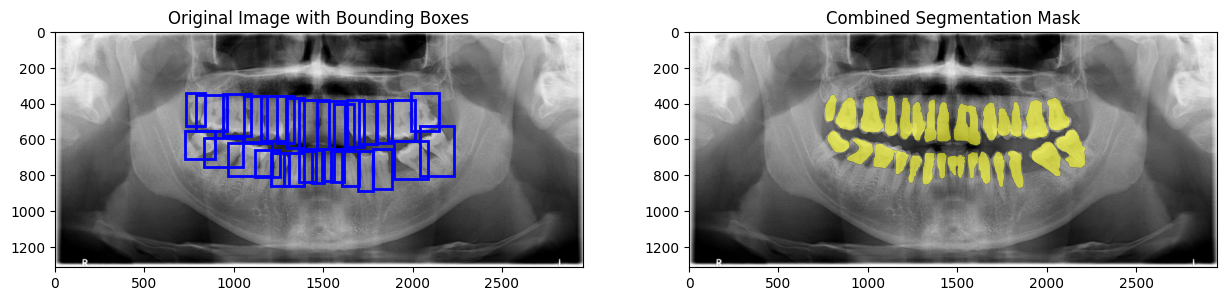

In [ ]:
# Load the checkpoint on CPU
checkpoint = torch.load(MedSAM_CKPT_PATH, map_location=torch.device('cpu'))

# Initialize the MedSAM model and load the state dict
medsam_model = sam_model_registry['vit_b']()
medsam_model.load_state_dict(checkpoint)
medsam_model = medsam_model.to(device)
medsam_model.eval()

# %% Load and preprocess the image
img_path = "PATH/to/image"
img_np = io.imread(img_path)
img_3c = np.repeat(img_np[:, :, None], 3, axis=-1) if len(img_np.shape) == 2 else img_np
H, W, _ = img_3c.shape

# Resize to 1024x1024 for MedSAM
img_1024 = transform.resize(img_3c, (1024, 1024), order=3, preserve_range=True, anti_aliasing=True).astype(np.uint8)
img_1024 = (img_1024 - img_1024.min()) / np.clip(img_1024.max() - img_1024.min(), a_min=1e-8, a_max=None)
img_1024_tensor = torch.tensor(img_1024).float().permute(2, 0, 1).unsqueeze(0).to(device)

# Compute the image embedding once
with torch.no_grad():
    image_embedding = medsam_model.image_encoder(img_1024_tensor)

# %% Load YOLO annotations
yolo_annotation_path = "PATH/to/yolo_annotations"
all_masks = np.zeros((H, W), dtype=np.uint8)

with open(yolo_annotation_path, 'r') as f:
    for line in f:
        parts = line.strip().split()
        class_id, x_center, y_center, width, height = map(float, parts)

        # Convert YOLO format to pixel format
        x_center_pixel = x_center * W
        y_center_pixel = y_center * H
        width_pixel = width * W
        height_pixel = height * H

        x_min = x_center_pixel - (width_pixel / 2)
        y_min = y_center_pixel - (height_pixel / 2)
        x_max = x_center_pixel + (width_pixel / 2)
        y_max = y_center_pixel + (height_pixel / 2)

        # Scale box to 1024x1024
        box_1024 = np.array([x_min, y_min, x_max, y_max]) / np.array([W, H, W, H]) * 1024

        # Run MedSAM inference for this bounding box using the precomputed image embedding
        medsam_seg = medsam_inference(medsam_model, image_embedding, box_1024, H, W)

        # Place the mask back onto the full-size image
        mask_position = np.zeros((H, W), dtype=np.uint8)
        mask_position[int(y_min):int(y_max), int(x_min):int(x_max)] = medsam_seg[int(y_min):int(y_max), int(x_min):int(x_max)]
        all_masks = np.maximum(all_masks, mask_position)  # Combine masks
